In [3]:
%load_ext autoreload
%autoreload 2

from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import json
import sys
sys.path.append('../visualizations/phase_diagram_viz')
import utils as pd_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

### parameters 

In [117]:
#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10
amplitude_weight = 0.5

## Sobol sample
seed = 42
m_samples = 5 # 2**m_samples = n_samples

In [31]:
np.log(0.005)

np.float64(-5.298317366548036)

In [32]:
np.exp(0.005)

np.float64(1.005012520859401)

### 1. define ground truth functions

In [33]:
def particle_diameter(x_1, x_2, x_3):
    const = 57.36
    a = const
    b = 6*const
    c = 6*const

    diameter = a*np.log(x_1) + b*np.exp(x_2)+c*x_3

    
    return diameter

In [60]:
def particle_pdi_gaussian(x_1, x_2, x_3, mu_x=0.007, mu_y=0.025, mu_z=0.03, sigma_x1=0.08, sigma_x2=0.1, sigma_x3=5, amplitude=1, offset=1.1):
    """
    Computes the value of a 3D Gaussian function at (x, y, z).
    
    Parameters:
    x, y, z : float or np.array
        Input coordinates where the function is evaluated.
    mu_x, mu_y, mu_z : float
        Center (mean) of the Gaussian in each dimension.
    sigma_x, sigma_y, sigma_z : float
        Standard deviations in x, y, and z directions.
    amplitude : float
        Peak value of the Gaussian.
    offset : float
        Baseline offset added to the function.

    Returns:
    float or np.array
        The computed Gaussian function value.
    """
    exponent = -(((x_1 - mu_x)**2 / (2 * sigma_x1**2)) + 
                 ((x_2 - mu_y)**2 / (2 * sigma_x2**2)) + 
                 ((x_3 - mu_z)**2 / (2 * sigma_x3**2)))
    return -amplitude * np.exp(exponent) + offset


/tmp/ipykernel_1997/1600812931.py:7: RuntimeWarning: divide by zero encountered in log
  diameter = a*np.log(x_1) + b*np.exp(x_2)+c*x_3


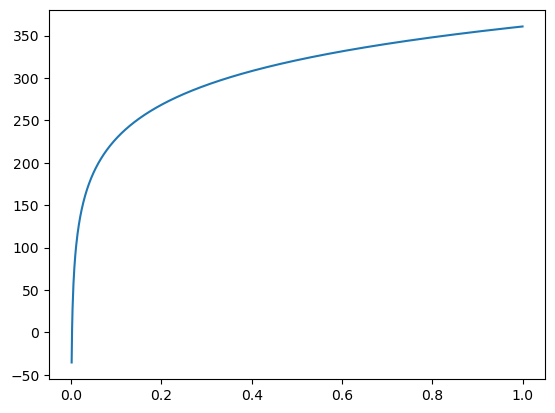

In [129]:
plt.plot(x, particle_diameter(x, 0.018, 0.03))

In [63]:
particle_pdi_gaussian(x, 0.025, 0.03)

array([0.10382081, 0.10280855, 0.10195122, ..., 1.1       , 1.1       ,
       1.1       ])

In [130]:
particle_diameter(0.007, 0.018, 0.04)

np.float64(79.56593330170878)

ValueError: x and y must have same first dimension, but have shapes (1001,) and (1,)

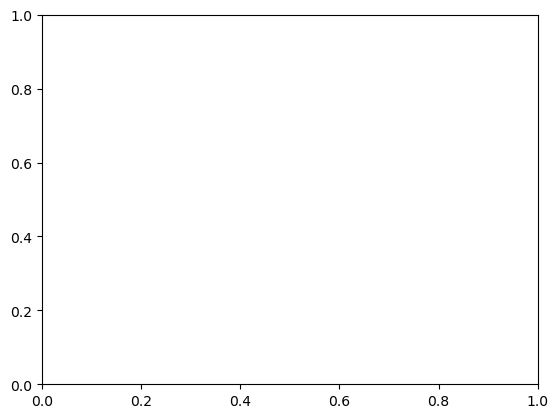

In [30]:
x = np.linspace(0, 1, 1001)
y = np.log(0.005)

plt.plot(x,y)

### 2. Calculate scattering

In [10]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [131]:
target_r_nm = 40
target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [132]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

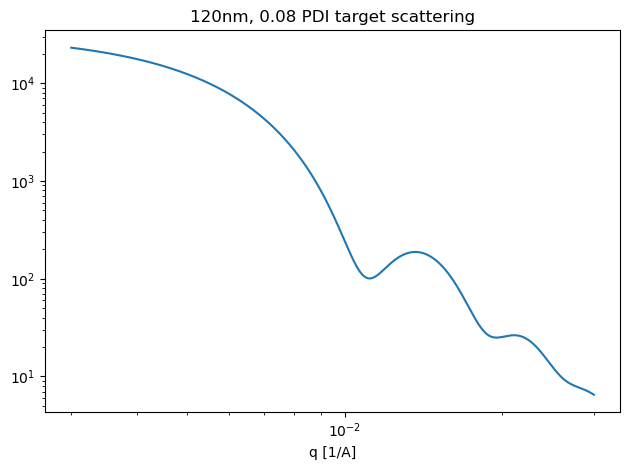

In [133]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()


## 3. put together 'experiment' code:

In [134]:
def syringe_precision(vol_frac, noise_frac):
    """
    vol_frac - volume fraction to be noised
    noise-frac - what fraction of full syringe uncertainty to use (0 is noise free, 1 is full)
    """
    if vol_frac <= 0.029:
        precision = noise_frac* (-3551*vol_frac + 110)/100
    else:
        precision = noise_frac*0.0073

    return precision

In [135]:
def noisy_dispense(vol_frac, noise_frac):
    """
    calculate the 'noisy' amount to 'dispense' when calculating diameter, pdi

    vol frac - volume fraction 'called for' by planner
    noise_frac - noise parameter, [0,1], 1 is syringe noise, 0 is noise free
    """

    vol_std = syringe_precision(vol_frac, noise_frac)*vol_frac
    sampled_vol_frac = np.random.normal(loc = vol_frac, scale=vol_std)
    if sampled_vol_frac < 0:
        sampled_vol_frac = 0
    return sampled_vol_frac

In [139]:
# something provides volume fractions to use
noise_frac = 1
sample_point = [0.007, 0.018, 0.04]
# 1. calculate uncertainty on those volume fractions: 

noisy_sample_point = [noisy_dispense(sample_point[0], noise_frac), noisy_dispense(sample_point[1], noise_frac), noisy_dispense(sample_point[2], noise_frac)]

diameter = particle_diameter(noisy_sample_point[0], noisy_sample_point[1], noisy_sample_point[2])
pdi = particle_pdi_gaussian(noisy_sample_point[0], noisy_sample_point[1], noisy_sample_point[2])

target_r_angs = diameter*10/2


scattering = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, pdi, sld_silica, sld_etoh)

In [140]:
diameter

np.float64(72.40746713705413)

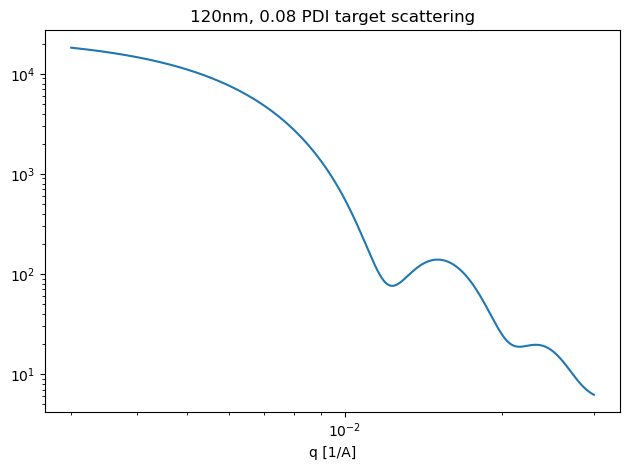

In [141]:
fig, ax = plt.subplots()
ax.loglog(q_grid_nonlog, scattering)
ax.set_xlabel('q [1/A]')
ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()

In [142]:
q_grid

array([-2.52287875, -2.52187875, -2.52087875, ..., -1.52487875,
       -1.52387875, -1.52287875])

## 4. Data processing

- just do scaling and AP distance here

In [143]:
def process_measurement(scattering, target_I, q_grid, amplitude_weight):
    # processing works in log(I) space 

    
    scattering = np.log10(scattering)
    target_I = np.log10(target_I)
    I_scaled = manipulate.scale_intensity_highqavg(scattering, target_I, n_avg = n_avg)
    amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)

    ap_sum = amplitude_weight*amplitude + (1-amplitude_weight)*phase

    return ap_sum

In [144]:
process_measurement(scattering, target_I, q_grid, amplitude_weight)

np.float64(0.6138462120655134)

## 5. BO 

function call to do BO 

In [ ]:
BATCH_SIZE = 10  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32



## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data


In [145]:
y_data_norm = normalize(y_data, (y_data.min(), y_data.max())).reshape(-1,1)
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

x_data_torch = torch.tensor(x_data.to_numpy())
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

NameError: name 'normalize' is not defined

In [ ]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = ard_num_dims)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        #train_Yvar=assumed_noise*torch.ones_like(train_y),
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [ ]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [ ]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y, ard_num_dims = ard_num_dims)

t0 = time.monotonic()

# fit the models

fit_mll = fit_gpytorch_mll(mll_nei)

In [ ]:
# define the qEI and qNEI acquisition modules using a QMC sampler
t_acqf = time.time()
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True,
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)
print(f'Optimized acqf in {time.time() - t_acqf} s')

In [ ]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

## 6. Initial random sampling
Do sobol sampling here with n as a parameter

In [ ]:
sampler = Sobol(d=3, seed = seed)
sampled_points = sampler.random_base2(m_samples)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].scatter(sampled_points[:,0], sampled_points[:,1])
ax[1].scatter(sampled_points[:,0], sampled_points[:,2])

In [ ]:
with open('constants_Round2_2025_01_13.json', 'rt') as f:
    constants = json.load(f)

In [ ]:
lower_bounds = [constants['TEOS']['minimum_volume_fraction'], constants['ammonia']['minimum_volume_fraction'], constants['water']['minimum_volume_fraction']]
upper_bounds = [constants['TEOS']['maximum_volume_fraction'], constants['ammonia']['maximum_volume_fraction'], constants['water']['maximum_volume_fraction']]

In [ ]:
sampled_volume_fractions = qmc.scale(sampled_points, lower_bounds, upper_bounds)

## 7. Run experiment loop

- BO to get next batch of points
- run experiment and calculate distance


data structure:
- uuid indexed dict
- uuid generated when compositions generated
- track vol fracs (desired), vol fracs (real), scattering, ap distance

BO sees vol fracs (desired) and AP distance

In [ ]:
# 1. call sobol sampling to generate samples

# 2. 'measure' sobol samples

#2.5 data process sobol samples

# 3. start experiment loop:
# 3a. Prepare and run BO
#3b. measure BO samples
#3c. post process and update datae 

## 8. Analyze 

Look at how things converged